# Medicare Public Use Files 2008-2010

## County-level Aggregated Factor Analysis of Higher Than Average Cost Counties

DeSYNPuf Counties Aggregate with Average Elixhauser Scores per User & RWJF Health Factor Rankings Dataset

Kyle P. Rasku RN BSN

Last Updated 7/16/2021

In [1]:
%matplotlib inline
import seaborn as sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.preprocessing as pre

The file contains aggregated Medicare data from 2008-2010 (DeSYNPuf Synthetic Public Use Files), and the RWJF/UW Madison  County Health Factors and Outcomes Ranking scores for each county that had scores in 2010.

1042 out of 3010 counties will be analyzed.  67 counties with outlying cost were removed.

The 3010 original counties were initially reduced to 2909 by removing a few outliers and by removing the counties that were not ranked by the RWJF/UW Madison rankings and removing counties with zero users for the time period (2008-2010).

Then, the 2909 counties were subjected to a GLM gamma regression risk adjustment model, created by my colleague Dhara Kapoor.  The RAM was designed to risk adjust against the outcome of cost, using demographic and illness covariates including: Beneficiary Age, Sex, Race, Elixhauser Score, Number of Chronic Conditions and the RWJF Factors Ranking for the county.  The factors ranking represents a sophisticated weighted measurement for each county that takes all social determinants of health, environmental factors and the health care system in the county.  After running this model, 1109 had higher cost than predicted by the model, so these were subsetted for factor analysis (after removing 67 extreme outliers) resulting in an analysis of 1042 counties. 

During this course, I learned how to perform a more thorough factor analysis than the one I originally performed on this data back in May and early June.  So, this is a re-do of a prior project, but I hope to come out with more accurate and dilligent results and to learn even more about the important variables related to Medicare costs at the county level.

In [4]:
medicare_counties = pd.read_csv("HIGHER_THAN_PREDICTED.csv")
medicare_counties.shape


(1109, 73)

Remove 67 outliers with extreme cost.

In [5]:
medicare_counties = medicare_counties[medicare_counties["TOT_COST_PB"]<200000]
medicare_counties.shape

(1042, 73)

In [19]:
medicare_counties.loc[medicare_counties["TOT_COST_PB"]>100000, "COST100KPB"] = 1
medicare_counties.loc[medicare_counties["TOT_COST_PB"]<=100000, "COST100KPB"] = 0

In [20]:
medicare_counties["COST100KPB"].value_counts()

0.0    758
1.0    284
Name: COST100KPB, dtype: int64

Split into training and test sets, stratified on the variable COST100KPB to retain the proportion of counties with higher costs per beneficiary.

In [21]:
medicare_counties.reset_index(inplace=True)
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=32576)
for train_ix, test_ix in split.split(medicare_counties, medicare_counties["COST100KPB"]):
    mc_train = medicare_counties.loc[train_ix]
    mc_test = medicare_counties.loc[test_ix]

## Factor Analysis

The purpose of this notebook is to search for Latent Explanatory "Super Variables" or Factors within the data set.

Are there larger, underlying concepts that group together the important variables in the analysis in terms of their covariance?  Exploratory Factor Analysis is the way to investigate this.

In [22]:
from factor_analyzer import FactorAnalyzer

Prepare for Factor Analysis by subsetting to potentially significant variables from the training data set, and dropping NULLs.

The following variables will be explored:

CNTY_USR_PROP The proportion of users (beneficiaries with >0 claims during the period) in the county

TOT_ESRD_PREV The prevalence of end-stage renal disease in the county

TOT_CVRG_MOS_PB_PY The average number of Medicare coverage months in the past year, per beneficiary

TOT_RXCVRG_MOS_PB_PY The average number of Part D coverage months in the past year, per beneficiary

TOT_IP_VSTS_PU The total number of inpatient admissions per user for the county

TOT_OP_VSTS_PU The total number of outpatient visits per user for the county

CODES_PU The total number of codes for all the claims for all the users in a county / the # of users

PROCS_PU The total number of procedures for all the claims for all the users in a county / the # of users

PRVDRS_PU The total number of unique providers recorded for all the claims for all the users in a county / the # of users

TOT_IPDAYS_PU The total length of stay for all the users in the county / # of users

TOT_CC_PREV The total # of chronic conditions per beneficiary for a county

TOT_CC_INCD The total # of new chronic conditions during the period per beneficiary for a county

TOT_ELIX_PU The total Elixhauser Score for all the users in a county / # of users

TOT_COST_PB The total cost for all the county's users / # of beneficiaries (this reflects the fact that even though not everyone in a county uses Medicare, the cost is spread across the population)

HO_PROP_RANK The RWJF Health Outcomes Rank for the county as a proportion (1 - county rank / # of ranked counties in the state)

HF_PROP_RANK The RWJF Health Factors Rank for the county as a proportion (1 - county rank / # of ranked counties in the state)

DIVERSE_PROP The proportion of beneficiaries in the county who identified their race as not white

In [25]:
analysis_ds = mc_train[["CNTY_USR_PROP", "TOT_ESRD_PREV", "TOT_CVRG_MOS_PB_PY", "TOT_RXCVRG_MOS_PB_PY",
                        "TOT_IP_VSTS_PU", "TOT_OP_VSTS_PU", "CODES_PU", "PROCS_PU", "PRVDRS_PU", 
                        "TOT_IPDAYS_PU", "TOT_CC_PREV", "TOT_CC_INCD", "TOT_ELIX_PU", "TOT_COST_PB", 
                        "HO_PROP_RANK", "HF_PROP_RANK", "DIVERSE_PROP"]]

analysis_ds = analysis_ds.dropna()
analysis_ds.shape


(833, 17)

In [26]:
analysis_ds

,CNTY_USR_PROP,TOT_ESRD_PREV,TOT_CVRG_MOS_PB_PY,TOT_RXCVRG_MOS_PB_PY,TOT_IP_VSTS_PU,TOT_OP_VSTS_PU,CODES_PU,PROCS_PU,PRVDRS_PU,TOT_IPDAYS_PU,TOT_CC_PREV,TOT_CC_INCD,TOT_ELIX_PU,TOT_COST_PB,HO_PROP_RANK,HF_PROP_RANK,DIVERSE_PROP
144,0.833333,0.166667,11.333333,8.388889,1.200000,7.600000,8.733333,8.133333,2.066667,3.400000,4.166667,1.333333,1.388889,55442.666667,0.162,0.354,0.000000
732,0.666667,0.200000,10.000000,7.259259,0.633333,9.500000,10.188889,12.872222,2.127778,4.000000,3.822222,2.066667,1.496828,57040.133333,0.442,0.494,0.155556
995,0.780083,0.224066,11.652835,8.930844,0.952128,8.361702,10.404255,10.593972,2.896277,5.053191,4.265560,2.066390,1.535502,64493.792531,0.627,0.761,0.165975
795,0.791667,0.208333,11.055556,9.006944,0.894737,10.868421,12.982456,15.815789,3.157895,4.868421,4.437500,1.979167,1.816745,96916.833333,0.643,0.786,0.083333
925,0.618705,0.172662,11.124700,7.958034,0.709302,8.534884,10.284884,11.426357,2.036822,3.639535,3.093525,1.388489,1.372659,55654.000000,0.909,0.848,0.064748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,0.700000,0.100000,11.400000,9.350000,0.714286,9.428571,10.166667,10.714286,2.119048,2.000000,4.250000,1.950000,1.127438,48223.200000,0.146,0.159,0.000000
681,0.806452,0.225806,11.215054,8.053763,0.480000,8.200000,9.600000,9.546667,2.093333,2.240000,3.903226,1.677419,1.204012,57096.387097,0.313,0.448,0.193548
524,0.761905,0.190476,11.063492,8.484127,0.625000,15.812500,17.062500,17.916667,3.333333,5.750000,4.904762,2.190476,1.637981,86035.428571,0.400,0.660,0.285714
992,0.759494,0.219409,11.057665,8.170183,0.705556,9.655556,10.784259,12.533333,2.041667,4.122222,4.367089,1.780591,1.486671,65102.151899,0.359,0.333,0.101266


## Spearman Correlation

Examine correlations to develop hypotheses about factor discovery.

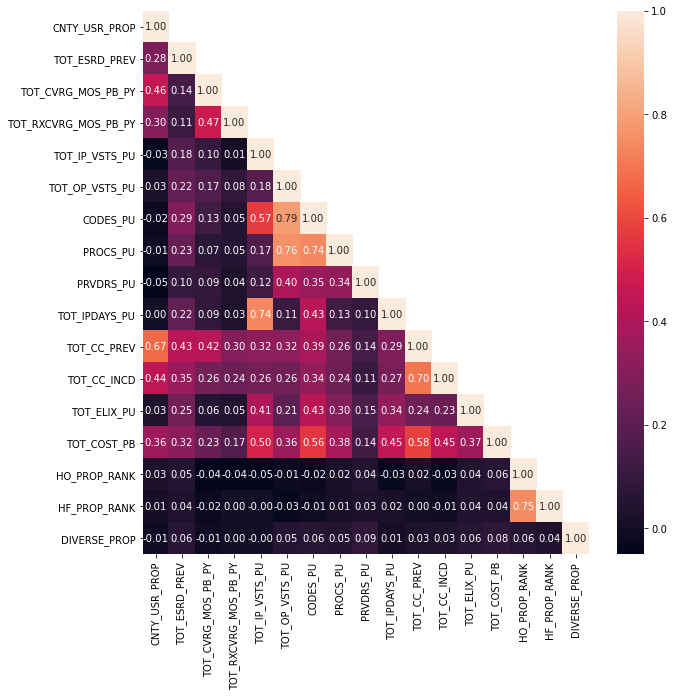

In [27]:
analysis_corr = analysis_ds.corr(method="spearman")
lower_corr = analysis_corr.where(np.tril(np.ones(analysis_corr.shape)).astype(np.bool))

plt.rcParams["figure.figsize"] = (10.0, 10.0)
analysis_hmap=sb.heatmap(lower_corr, annot=True, fmt=".2f")
fig = analysis_hmap.get_figure()

fig.savefig("factor_analysis_heatmap.png")

## Bartlett Test for Sphericity

A significant result (low p-value) indicates that a Factor Analysis may be appropriate.

In [28]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(analysis_ds)
chi_square_value, p_value

(8058.628107654718, 0.0)

## Kaiser-Meyer-Olkin (KMO) Test 

This test measures the suitability of the specific variables in the data set, and the model as a whole, for factor analysis. 

It estimates the *proportion of variance* among all the observed variables, and values range between 0 and 1. 

**Value less than 0.6 are likely to be inadequate**.

In [29]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(analysis_ds)
kmo_model

0.7411124005179986

In [30]:
kmo_all

array([0.72742252, 0.85879181, 0.77997846, 0.80841459, 0.57385007,
       0.69464912, 0.68006212, 0.80207228, 0.94117051, 0.83634879,
       0.78099171, 0.85705786, 0.86755101, 0.91247954, 0.49748189,
       0.50016418, 0.62763378])

### These results indicate that some of the variables may be inadequate.

Specifically, variable 5 (Inpatient Visits per User), and variable 15 and 16 (RWJF Ranks).

The other variables are adequate (>.6).  

To remove variables based on the results of the KMO test, we should drop the **lowest value** variable first and re-run the test - removing only one variable at a time.

In [31]:
analysis_ds = analysis_ds.drop("HF_PROP_RANK", axis=1)
kmo_all,kmo_model=calculate_kmo(analysis_ds)
kmo_model

0.7611989512962332

In [32]:
kmo_all

array([0.7275139 , 0.8597337 , 0.78038785, 0.80684996, 0.57280474,
       0.6942001 , 0.68026284, 0.80210912, 0.93865614, 0.83569341,
       0.78042013, 0.85716654, 0.86718473, 0.91174363, 0.36245645,
       0.65014504])

Now we remove HO_PROP_RANK.

In [33]:
analysis_ds = analysis_ds.drop("HO_PROP_RANK", axis=1)
kmo_all,kmo_model=calculate_kmo(analysis_ds)
kmo_model

0.7630106810379094

In [34]:
kmo_all

array([0.72829011, 0.85718386, 0.78073041, 0.81302827, 0.57426439,
       0.69540601, 0.67929885, 0.8008783 , 0.94539967, 0.8360375 ,
       0.78146774, 0.85859863, 0.8658782 , 0.91490488, 0.64442828])

In spite of it's inadequate score, TOT_IP_VSTS_PU will be retained.

This variable helps represent inpatient admissions in the variance, and the only other related variable is TOT_IPDAYS_PU.

In [35]:
analysis_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 833 entries, 144 to 585
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CNTY_USR_PROP         833 non-null    float64
 1   TOT_ESRD_PREV         833 non-null    float64
 2   TOT_CVRG_MOS_PB_PY    833 non-null    float64
 3   TOT_RXCVRG_MOS_PB_PY  833 non-null    float64
 4   TOT_IP_VSTS_PU        833 non-null    float64
 5   TOT_OP_VSTS_PU        833 non-null    float64
 6   CODES_PU              833 non-null    float64
 7   PROCS_PU              833 non-null    float64
 8   PRVDRS_PU             833 non-null    float64
 9   TOT_IPDAYS_PU         833 non-null    float64
 10  TOT_CC_PREV           833 non-null    float64
 11  TOT_CC_INCD           833 non-null    float64
 12  TOT_ELIX_PU           833 non-null    float64
 13  TOT_COST_PB           833 non-null    float64
 14  DIVERSE_PROP          833 non-null    float64
dtypes: float64(15)
memory

The final 15 variables look good, and the overall KMO score is 76%.

Now, we can attempt the factor analysis on these Counties with Higher Than Predicted Cost.

The most meritorious variable is Providers per User (.945), and the second is Total Cost per Beneficiary (.915)

In [36]:
# Save a copy before transforming to an np.array

analysis_ds_copy = analysis_ds.copy()

## Standardize the Data

In [37]:
s = pre.StandardScaler()
analysis_ds = s.fit_transform(analysis_ds)

## Kaiser Criterion & Scree Plot

Examining Eigenvalues to determine the number of observable factors (Latent variables).

In [38]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(method='ml', rotation=None)
fa.fit(analysis_ds)

FactorAnalyzer(method='ml', rotation=None, rotation_kwargs={})

In [40]:
## Show the Unrotated Loadings

fa.loadings_

array([[-0.09280886,  0.43929936,  0.72169273],
       [ 0.21481451,  0.24973027,  0.29196598],
       [ 0.07956274,  0.26622441,  0.4522028 ],
       [ 0.02314763,  0.20013305,  0.38024509],
       [ 0.57506113,  0.60865933, -0.47287859],
       [ 0.83784514, -0.33708201,  0.27169864],
       [ 0.99727096, -0.01994128, -0.00754428],
       [ 0.79633595, -0.3426912 ,  0.21563461],
       [ 0.47113442, -0.13750308,  0.11492635],
       [ 0.39412979,  0.52793061, -0.37207895],
       [ 0.37153235,  0.58667009,  0.63899426],
       [ 0.30670579,  0.48544529,  0.44119213],
       [ 0.39553241,  0.28452368, -0.11719233],
       [ 0.5265784 ,  0.41642221,  0.18524893],
       [ 0.06924395, -0.06793589,  0.03992699]])

In [41]:
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([4.5286809 , 2.59430785, 1.85241984, 1.03675669, 0.95286386,
       0.73988956, 0.70073565, 0.63680982, 0.54959603, 0.47721903,
       0.32995886, 0.2714699 , 0.1547966 , 0.13426536, 0.04023005])

There are 4 eigenvalues > 1, and a fifth that is close to 1.

It is not, in my view, close enough to be included in the analysis, however.

So 4 factors will be retained.

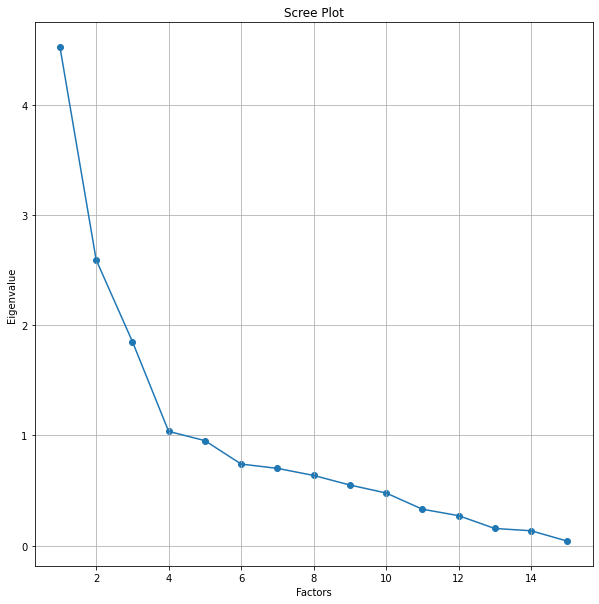

In [43]:
# Create scree plot 
plt.scatter(range(1,analysis_ds.shape[1]+1),ev)
plt.plot(range(1,analysis_ds.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

## Orthogonal Rotation: VARIMAX

In [46]:
fa = FactorAnalyzer(method="ml", rotation="varimax", n_factors=4)
fa.fit(analysis_ds)
fa.loadings_

array([[-0.14014465,  0.82705542, -0.11504871,  0.09329681],
       [ 0.10409101,  0.38003906,  0.13714224,  0.222454  ],
       [ 0.06029939,  0.55723478, -0.02298162, -0.16123445],
       [ 0.01755553,  0.44188542, -0.05566946, -0.06001901],
       [ 0.09812319,  0.01370284,  0.98023814, -0.15595161],
       [ 0.96216687,  0.13272115,  0.04808903, -0.05239999],
       [ 0.84187089,  0.0775913 ,  0.50368733,  0.07961598],
       [ 0.87189045,  0.04338457,  0.08751965,  0.22300948],
       [ 0.51038652,  0.07610609,  0.0852977 , -0.08330115],
       [ 0.01309156,  0.02271631,  0.74359348,  0.0070002 ],
       [ 0.1732173 ,  0.88179086,  0.26071478,  0.09369424],
       [ 0.11567329,  0.65055913,  0.26372841,  0.14575752],
       [ 0.13926516,  0.06397839,  0.48258364,  0.3145983 ],
       [ 0.26794565,  0.41298866,  0.47930978,  0.24544397],
       [ 0.09958542, -0.00629687, -0.02097482,  0.06467087]])

## Oblique Rotation: QUARTIMIN

In [47]:
fa2 = FactorAnalyzer(method="ml", rotation="quartimin", n_factors=4)
fa2.fit(analysis_ds)
fa2.loadings_

array([[-0.16991191,  0.85855433, -0.19535789, -0.01754751],
       [ 0.06053975,  0.39382032, -0.02841879,  0.20369894],
       [ 0.06105677,  0.54458866,  0.02016276, -0.25501284],
       [ 0.0151973 ,  0.44033891, -0.05218585, -0.13321357],
       [-0.00108252, -0.00340672,  1.00459003, -0.016925  ],
       [ 1.00501584,  0.03435258, -0.06579171, -0.13569658],
       [ 0.81452199,  0.00415161,  0.31748169,  0.0963787 ],
       [ 0.88452668, -0.02383398, -0.15856226,  0.18508319],
       [ 0.53060354,  0.01969121,  0.05167921, -0.1226583 ],
       [-0.07660146,  0.02649297,  0.70202934,  0.12465626],
       [ 0.11240562,  0.88489779,  0.11642773,  0.01414425],
       [ 0.05497891,  0.66087686,  0.11428121,  0.10530411],
       [ 0.05895669,  0.07995674,  0.26729291,  0.39818824],
       [ 0.18859812,  0.41470978,  0.26096057,  0.2679077 ],
       [ 0.10170413, -0.01101061, -0.06804841,  0.05971595]])

## Cross-loading Analysis & Rotational Evaluation

The VARIMAX rotations involve 3 variables that need evaluation for cross-loading: 2, 13 and 14.  And variable 15 really isn't related to any of the factors, not even with a loading of .1

The QUARTIMIN rotations are a bit better separated.  There are only 2 variables that need evaluation for cross-loading: 2 and 13. 

Variable 2: Total End-Stage Renal Disease Prevalence (TOT_ESRD_PREV)
Factor 2 loading: .39 vs. Factor 4 loading .20.  Variance ratio: 3.8, and only the Factor 2 loading is above significance.  We can ignore this cross-loading.

Variable 13: Total Elixhauser Score per User (TOT_ELIX_PU)
Factor 3 loading: .267 vs. Factor 4 loading .398. Variance ratio: 2.22, and only the Factor 4 loading is above significance.  We can also ignore this cross-loading.

The analysis will be continued using the QUARTIMIN rotation.

In [50]:
analysis_ds_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 833 entries, 144 to 585
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CNTY_USR_PROP         833 non-null    float64
 1   TOT_ESRD_PREV         833 non-null    float64
 2   TOT_CVRG_MOS_PB_PY    833 non-null    float64
 3   TOT_RXCVRG_MOS_PB_PY  833 non-null    float64
 4   TOT_IP_VSTS_PU        833 non-null    float64
 5   TOT_OP_VSTS_PU        833 non-null    float64
 6   CODES_PU              833 non-null    float64
 7   PROCS_PU              833 non-null    float64
 8   PRVDRS_PU             833 non-null    float64
 9   TOT_IPDAYS_PU         833 non-null    float64
 10  TOT_CC_PREV           833 non-null    float64
 11  TOT_CC_INCD           833 non-null    float64
 12  TOT_ELIX_PU           833 non-null    float64
 13  TOT_COST_PB           833 non-null    float64
 14  DIVERSE_PROP          833 non-null    float64
dtypes: float64(15)
memory

In [48]:
fa2.loadings_

array([[-0.16991191,  0.85855433, -0.19535789, -0.01754751],
       [ 0.06053975,  0.39382032, -0.02841879,  0.20369894],
       [ 0.06105677,  0.54458866,  0.02016276, -0.25501284],
       [ 0.0151973 ,  0.44033891, -0.05218585, -0.13321357],
       [-0.00108252, -0.00340672,  1.00459003, -0.016925  ],
       [ 1.00501584,  0.03435258, -0.06579171, -0.13569658],
       [ 0.81452199,  0.00415161,  0.31748169,  0.0963787 ],
       [ 0.88452668, -0.02383398, -0.15856226,  0.18508319],
       [ 0.53060354,  0.01969121,  0.05167921, -0.1226583 ],
       [-0.07660146,  0.02649297,  0.70202934,  0.12465626],
       [ 0.11240562,  0.88489779,  0.11642773,  0.01414425],
       [ 0.05497891,  0.66087686,  0.11428121,  0.10530411],
       [ 0.05895669,  0.07995674,  0.26729291,  0.39818824],
       [ 0.18859812,  0.41470978,  0.26096057,  0.2679077 ],
       [ 0.10170413, -0.01101061, -0.06804841,  0.05971595]])

## The QUARTIMIN Loadings Analysis

**Factor 1** Highest loading (>1), variable 6 - Total # of Outpatient Visits per User (TOT_OP_VSTS_PU). Other very high loadings (>.8) occur on variable 7 and 8, Codes per User (CODES_PU) and Procedures per User (PROCS_PU).  There is a moderately high loading on variable 9 (.53), Providers per User (PRVDRS_PU). This factor loads at .19 against the Total Cost per Beneficiary. This factors loads highest for non-white individuals (.1). **This is a health care industry utilization factor**.

**Factor 2** has the highest loadings on variable 11 (.88) Total Chronic-Conditions Prevalence (TOT_CC_PREV) and variable 1 (.86), County User Proportion.  It also has high loading on variable 12 (.66), Total Chronic-Condition Incidence (TOT_CC_INCD).  It has moderate/solid loadings on variable 3 (.54) and 4 (.44), the two Coverage Months per Year per Beneficiary Variables (TOT_CVRG_MOS_PB_PY and TOT_RXCVRG_MOS_PB_PY) and on variable 2 (.39), Total End-Stage Renal Disease Prevalence (TOT_ESRD_PREV). This factor loads at .41 against the Total Cost per Beneficiary. This is the highest cost loading. **This is a utilization due to illness combined with the ability to access coverage and care factor**.

**Factor 3** has the highest loading (1) on variable 5 - Total # of Inpatient Visits per User (TOT_IP_VSTS_PU).  Other very high loadings occur on variable 10 (.70), Number of Inpatient Days per User (TOT_IPDAYS_PU). This factor carries some of the variance of other variables that are more significant on another factor, such as 7 (CODES_PU), and variable 13 (TOT_ELIX_PU).  This factor loads fairly significantly negatively (about -.15 to -.2) on variable 1 (CNTY_USR_PROP) and variable 8 (PRVDRS_PU).  This factor loads at .26 against the Total Cost per Beneficiary (tied with Factor 4).  This is the second highest loading for cost.  **This is a hospitalization factor.**

**Factor 4** has the highest loading on its only significant variable (.39), Total Elixhauser Score per User (TOT_ELIX_PU).  This is a score associated with fragile health and includes scoring for a combination of illness severity, lifestyle problems, and mental health issues. This factor also loads at .267 against the Total Cost per Beneficiary (tied with, and just edging out Factor 3 for second-highest cost loading). This factor also takes a positive share of variable 2 (ESRD_PREV) and is highly negatively associated with variables 3 and 4 (Medicare insurance coverage and Prescription Drug coverage), and variable 6 (Outpatient visits) and variable 9 (Providers). This factor loads the second highest for non-white individuals. **This is utilization due to health fragility, and possibly social determinants irrespective of primary care or coverage.**

In [51]:
fa2.get_communalities()

array([0.80445822, 0.20106039, 0.36574282, 0.21459853, 1.00950036,
       1.03397905, 0.77354679, 0.84235329, 0.29964365, 0.51495404,
       0.8094346 , 0.46393005, 0.23986834, 0.34742841, 0.01866154])

## Communality

The amount of these variables' variance explained by their loading on the factors.

Highest explained: 5 Inpatient Visits, 6 Outpatient Visits, and 8 Procedures per User.

In [52]:
fa2.get_factor_variance()

(array([2.84484002, 2.78385261, 1.84787658, 0.46259089]),
 array([0.189656  , 0.18559017, 0.12319177, 0.03083939]),
 array([0.189656  , 0.37524618, 0.49843795, 0.52927734]))

## Factor Variance

First array: Sum of squared loadings (total factor variance)

Second array: Proportional variance of that factor vs. other factors

Third array: Cumulative variance of all factors (from left to right)


The **First Factor** is the most significant, the **Second and Third Factors** are also very significant, and the **Third Factor** is quite a bit less significant in explaining the overall variance.

The three factors together account for approximately **53%** of the total variance in these variables.

In [53]:
fa2.get_uniquenesses()

array([ 0.19554178,  0.79893961,  0.63425718,  0.78540147, -0.00950036,
       -0.03397905,  0.22645321,  0.15764671,  0.70035635,  0.48504596,
        0.1905654 ,  0.53606995,  0.76013166,  0.65257159,  0.98133846])

## Uniquenesses

These are variances associated with only a specific varible.

The variables with highest uniqueness of variation are variables 2, 3, 4, 9, 10, 13, 14 and 15.

This suggests these variables "are what they are" and that while they may be influential, they are not easily influenced or fully explained.  Note that this includes the cost variable (.65). 

In [54]:
# Reducing the data set based on the four factors 

df_reduced = fa2.fit_transform(analysis_ds)
df_reduced

array([[ 0.53892554, -1.12790619, -0.02856427, -1.29177883],
       [-0.79667578, -0.24372104, -0.55692777, -0.04580448],
       [-0.02295283, -0.52226035,  0.13515767, -0.34897936],
       ...,
       [-0.77925299,  2.22627983,  0.43170354,  0.12088211],
       [-0.61886442, -0.13868949,  0.04332801, -0.22728669],
       [-0.42257828,  0.14633394, -1.2179782 ,  0.0382276 ]])

In [55]:
FACTORS = pd.DataFrame(df_reduced, columns =["FACTORS_1", "FACTORS_2", "FACTORS_3", "FACTORS_4"])


In [57]:
mc_train.shape

(833, 77)

In [58]:
merged = mc_train.merge(FACTORS, left_index=True, right_index=True)

In [59]:
merged

,level_0,index,FIPS_STATE_CODE,FIPS_COUNTY_CODE,CNTY_BENE_CT,CNTY_BENE_USRS,CNTY_MEAN_AGE,CNTY_SEX_PROP,TOT_CNCR_CASES,TOT_STRKETIA_CASES,...,Lower 95% Mean TOT_COST_PB,Upper 95% Mean TOT_COST_PB,Residuals,HIGHER_COST,ANYCOSTS,COST100KPB,FACTORS_1,FACTORS_2,FACTORS_3,FACTORS_4
144,144,177,20,181,6,5,77.6,0.333333,0,0,...,47893.662336,51981.282080,5547.035878,1,0.0,0.0,0.152382,-0.408872,0.256349,-0.504286
732,732,799,40,37,45,30,71.2,0.511111,5,6,...,49810.990927,52805.442795,5753.766413,1,0.0,0.0,0.823087,0.646933,-0.013095,0.166788
795,795,862,25,15,48,38,73.3,0.479167,6,7,...,62584.378878,67312.399715,32011.481266,1,0.0,0.0,0.097894,0.087221,0.748627,0.152618
434,434,495,46,135,18,12,79.1,0.444444,3,2,...,36672.380743,40519.081715,19362.777513,1,0.0,0.0,-0.744836,-0.179653,0.573914,-0.256155
289,289,341,31,47,11,8,72.6,0.363636,1,0,...,34369.055734,38349.205152,28784.827165,1,0.0,0.0,0.677588,0.080290,2.581315,-1.140913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,403,462,48,481,12,11,75.7,0.416667,2,0,...,43662.581899,47867.059812,44861.655215,1,0.0,0.0,-0.340073,-0.026462,0.248124,0.102008
468,468,530,26,143,20,14,77.1,0.450000,3,2,...,44415.306823,48911.114443,1614.164877,1,0.0,0.0,-0.738744,-0.390088,-3.267398,-0.651496
681,681,748,12,63,31,25,75.7,0.580645,5,3,...,47411.187869,50895.982713,7973.693785,1,0.0,0.0,-0.520910,-0.353616,0.052271,-0.083367
524,524,587,37,3,21,16,69.3,0.380952,3,1,...,70125.141488,75420.431707,13310.821701,1,0.0,0.0,0.032018,0.740676,1.048561,0.037572


## Discover & Record the Dominant Factor for Each County

In [60]:
HIGH_F1 = merged[(merged["FACTORS_1"]>merged["FACTORS_2"]) & (merged["FACTORS_1"] > merged["FACTORS_3"]) & (merged["FACTORS_1"] > merged["FACTORS_4"])]
HIGH_F2 = merged[(merged["FACTORS_2"]>merged["FACTORS_1"]) & (merged["FACTORS_2"] > merged["FACTORS_3"]) & (merged["FACTORS_2"] > merged["FACTORS_4"])]
HIGH_F3 = merged[(merged["FACTORS_3"]>merged["FACTORS_1"]) & (merged["FACTORS_3"] > merged["FACTORS_2"]) & (merged["FACTORS_3"] > merged["FACTORS_4"])]
HIGH_F4 = merged[(merged["FACTORS_4"]>merged["FACTORS_1"]) & (merged["FACTORS_4"] > merged["FACTORS_2"]) & (merged["FACTORS_4"] > merged["FACTORS_3"])]

f1_rows = HIGH_F1.index.values
f2_rows = HIGH_F2.index.values
f3_rows = HIGH_F3.index.values
f4_rows = HIGH_F4.index.values

for f in f1_rows:
    merged.at[f,"D_FACTOR"] = 1

for f in f2_rows:
    merged.at[f, "D_FACTOR"] = 2

for f in f3_rows:
    merged.at[f, "D_FACTOR"] = 3
    
for f in f4_rows:
    merged.at[f, "D_FACTOR"] = 4

In [61]:
merged

,level_0,index,FIPS_STATE_CODE,FIPS_COUNTY_CODE,CNTY_BENE_CT,CNTY_BENE_USRS,CNTY_MEAN_AGE,CNTY_SEX_PROP,TOT_CNCR_CASES,TOT_STRKETIA_CASES,...,Upper 95% Mean TOT_COST_PB,Residuals,HIGHER_COST,ANYCOSTS,COST100KPB,FACTORS_1,FACTORS_2,FACTORS_3,FACTORS_4,D_FACTOR
144,144,177,20,181,6,5,77.6,0.333333,0,0,...,51981.282080,5547.035878,1,0.0,0.0,0.152382,-0.408872,0.256349,-0.504286,3.0
732,732,799,40,37,45,30,71.2,0.511111,5,6,...,52805.442795,5753.766413,1,0.0,0.0,0.823087,0.646933,-0.013095,0.166788,1.0
795,795,862,25,15,48,38,73.3,0.479167,6,7,...,67312.399715,32011.481266,1,0.0,0.0,0.097894,0.087221,0.748627,0.152618,3.0
434,434,495,46,135,18,12,79.1,0.444444,3,2,...,40519.081715,19362.777513,1,0.0,0.0,-0.744836,-0.179653,0.573914,-0.256155,3.0
289,289,341,31,47,11,8,72.6,0.363636,1,0,...,38349.205152,28784.827165,1,0.0,0.0,0.677588,0.080290,2.581315,-1.140913,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,403,462,48,481,12,11,75.7,0.416667,2,0,...,47867.059812,44861.655215,1,0.0,0.0,-0.340073,-0.026462,0.248124,0.102008,3.0
468,468,530,26,143,20,14,77.1,0.450000,3,2,...,48911.114443,1614.164877,1,0.0,0.0,-0.738744,-0.390088,-3.267398,-0.651496,2.0
681,681,748,12,63,31,25,75.7,0.580645,5,3,...,50895.982713,7973.693785,1,0.0,0.0,-0.520910,-0.353616,0.052271,-0.083367,3.0
524,524,587,37,3,21,16,69.3,0.380952,3,1,...,75420.431707,13310.821701,1,0.0,0.0,0.032018,0.740676,1.048561,0.037572,3.0


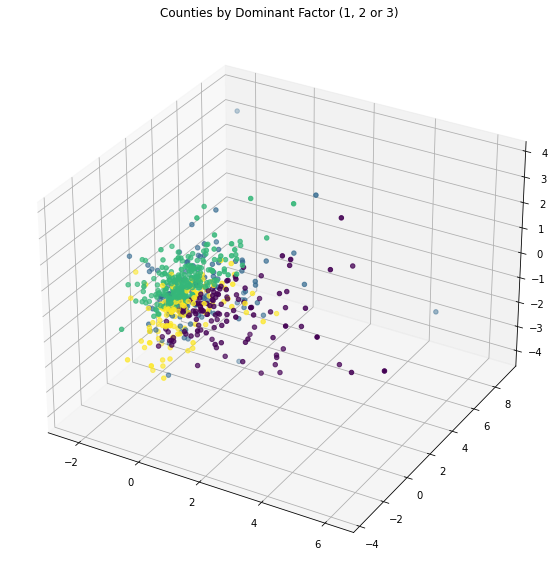

In [62]:
# Factor 4 is not graphed here because of its very small variance representation 
m_subset = merged.copy()

from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
z = m_subset["FACTORS_3"]
y = m_subset["FACTORS_2"]
x = m_subset["FACTORS_1"]
c = m_subset["D_FACTOR"]
ax.scatter(x, y, z, c=c)
ax.set_title('Counties by Dominant Factor (1, 2 or 3)')
plt.show()

In [63]:
merged["D_FACTOR"].value_counts()

3.0    250
2.0    155
4.0    138
1.0    120
Name: D_FACTOR, dtype: int64

The largest # of counties in our training data set have Factor 3 (Inpatient/Hospitalizations) and Factor 2 (Chronic Illness and Primary Care) dominance, the fewest have Factor 1 dominance (Utilization). 

## Highest Cost by Dominant Factor

Of the top 20 highest cost counties in this data set (outliers are removed here), 

2 out of 20 have Factor 1 dominance

3 out of 20 have Factor 2 dominance

13 out of 20 have Factor 3 dominance (Inpatient stays are very expensive)

and 2 out of 20 have Factor 4 dominance

Some counties still have negative values for all 4 factors, suggesting there are a great many things that account for cost (recall its high uniqueness as well - .65).  Nothing is as simple as 4 factors - however, these factors do tell a compelling story of some of the significant causes of cost among Medicare beneficiaries in the US.

In [65]:
# Highest Cost / ALL

hc = merged[["STATE", "COUNTY", "D_FACTOR", "FACTORS_1", "FACTORS_2", "FACTORS_3", "FACTORS_4", "DIVERSE_PROP", "HF_PROP_RANK", "HO_PROP_RANK", 
                 "TOT_CC_PREV", "TOT_ELIX_PU", "PROCS_PU", "PRVDRS_PU", "TOT_IPDAYS_PU", "TOT_COST_PB"]]

hc.sort_values(by="TOT_COST_PB", ascending=False).head(20)

,STATE,COUNTY,D_FACTOR,FACTORS_1,FACTORS_2,FACTORS_3,FACTORS_4,DIVERSE_PROP,HF_PROP_RANK,HO_PROP_RANK,TOT_CC_PREV,TOT_ELIX_PU,PROCS_PU,PRVDRS_PU,TOT_IPDAYS_PU,TOT_COST_PB
27,Kansas,Barber,3.0,1.322775,0.243359,1.805653,0.254483,0.000000,0.667,0.747,5.333333,1.556548,11.666667,3.000000,12.000000,198352.66667
204,Oklahoma,Major,3.0,-0.104182,0.343444,0.907870,0.220491,0.000000,0.987,0.675,6.285714,1.522363,22.055556,2.666667,8.500000,195182.57143
396,Oklahoma,Osage,3.0,0.500623,0.472018,1.413537,0.427548,0.000000,0.403,0.740,5.333333,1.742806,20.181818,2.393939,3.909091,195140.16667
197,Montana,Fergus,3.0,0.869653,-0.038380,1.203309,-1.406886,0.000000,0.568,0.864,4.875000,1.596142,12.777778,2.222222,9.833333,192211.75000
26,Iowa,Ringgold,1.0,0.106048,-0.912172,-1.072315,-0.108346,0.000000,0.505,0.657,8.000000,2.558730,18.333333,3.500000,6.500000,191897.00000
77,Montana,Carbon,2.0,-1.901031,1.167419,-0.067266,0.794521,0.000000,0.727,0.955,3.000000,2.136251,24.111111,1.777778,7.333333,191784.00000
512,Georgia,Bulloch,3.0,-0.709681,-0.277043,-0.209499,-0.695108,0.368421,0.701,0.758,4.315789,1.517427,13.187500,3.104167,7.625000,189265.26316
345,Kentucky,Perry,3.0,-0.327646,-0.231944,0.250682,0.129011,0.071429,0.133,0.033,4.285714,1.932037,16.266667,1.766667,3.500000,185009.00000
566,Illinois,Woodford,3.0,-0.058343,0.449413,1.194505,0.836615,0.260870,0.950,0.970,4.608696,2.143196,16.879630,2.361111,8.388889,184292.43478
93,Vermont,Grand Isle,3.0,0.303764,0.327812,0.503914,0.114070,0.000000,0.357,0.643,8.000000,2.127405,24.777778,2.888889,9.666667,183375.33333


In [66]:
factor1_df = merged[merged["D_FACTOR"] == 1]
factor2_df = merged[merged["D_FACTOR"] == 2]
factor3_df = merged[merged["D_FACTOR"] == 3]
factor4_df = merged[merged["D_FACTOR"] == 4]

## Top 10 Factor 1 Dominant Counties by Cost (Descending)

Some of these, like Dickinson, Kansas have high #s across the board, while others like Rolette, ND have negative #s.

In [69]:
uc = factor1_df[["STATE", "COUNTY", "FACTORS_1", "FACTORS_2", "FACTORS_3", "FACTORS_4", "DIVERSE_PROP", "HF_PROP_RANK", "HO_PROP_RANK", 
                 "TOT_CC_PREV", "TOT_ELIX_PU", "PROCS_PU", "PRVDRS_PU", "TOT_IPDAYS_PU", "TOT_COST_PB"]]

uc.sort_values(by="TOT_COST_PB", ascending=False).head(10)

,STATE,COUNTY,FACTORS_1,FACTORS_2,FACTORS_3,FACTORS_4,DIVERSE_PROP,HF_PROP_RANK,HO_PROP_RANK,TOT_CC_PREV,TOT_ELIX_PU,PROCS_PU,PRVDRS_PU,TOT_IPDAYS_PU,TOT_COST_PB
26,Iowa,Ringgold,0.106048,-0.912172,-1.072315,-0.108346,0.000000,0.505,0.657,8.000000,2.558730,18.333333,3.500000,6.500000,191897.00000
231,Kansas,Dickinson,1.582972,1.545362,0.714288,1.500670,0.000000,0.434,0.727,4.777778,1.888875,17.666667,3.000000,4.428571,172615.11111
691,Georgia,Thomas,1.264361,-0.895509,-1.003898,-1.226035,0.153846,0.561,0.414,6.000000,1.644697,11.602564,1.500000,9.115385,165422.00000
523,New York,Madison,1.455604,0.559582,0.596835,1.439501,0.526316,0.597,0.629,4.736842,1.886350,15.333333,3.437500,4.250000,164922.73684
38,North Dakota,Rolette,-0.478743,-0.831186,-1.587255,-0.683785,0.500000,0.000,0.045,5.000000,2.216667,4.333333,1.500000,10.500000,164190.00000
353,Mississippi,Lafayette,1.246503,0.533573,0.092180,0.930376,0.200000,0.951,0.951,3.800000,2.116970,17.733333,2.533333,8.600000,161913.06667
304,Idaho,Lewis,0.911018,-0.025057,0.013818,-0.134996,0.000000,0.214,0.024,6.444444,2.090313,17.111111,2.703704,14.444444,157213.77778
382,Michigan,Clare,1.740244,0.360424,0.023272,0.843871,0.294118,0.073,0.000,3.235294,1.544592,18.757576,3.393939,4.454545,153130.94118
329,Washington,Franklin,1.320724,-0.037529,-0.079485,-0.223643,0.076923,0.359,0.615,3.384615,1.123563,27.333333,2.148148,1.000000,147350.76923
138,Indiana,Newton,0.907726,-1.627618,0.589325,-0.180768,0.000000,0.478,0.217,3.428571,0.815397,14.266667,1.933333,6.200000,147035.71429


## Top 10 Factor 2 Dominant Counties by Cost (Descending)


In [71]:
ic = factor2_df[["STATE", "COUNTY", "FACTORS_1", "FACTORS_2", "FACTORS_3", "FACTORS_4", "DIVERSE_PROP", "HF_PROP_RANK", "HO_PROP_RANK", 
                 "TOT_CC_PREV", "TOT_ELIX_PU", "PROCS_PU", "PRVDRS_PU", "TOT_IPDAYS_PU", "TOT_COST_PB"]]

ic.sort_values(by="TOT_COST_PB", ascending=False).head(10)

,STATE,COUNTY,FACTORS_1,FACTORS_2,FACTORS_3,FACTORS_4,DIVERSE_PROP,HF_PROP_RANK,HO_PROP_RANK,TOT_CC_PREV,TOT_ELIX_PU,PROCS_PU,PRVDRS_PU,TOT_IPDAYS_PU,TOT_COST_PB
77,Montana,Carbon,-1.901031,1.167419,-0.067266,0.794521,0.000000,0.727,0.955,3.000000,2.136251,24.111111,1.777778,7.333333,191784.00000
741,Missouri,Cass,-0.707908,-0.190682,-0.314247,-0.423813,0.111111,0.887,0.913,5.333333,1.538183,15.258065,2.139785,9.193548,181573.16667
105,Iowa,Lyon,0.128395,0.883522,-0.934170,0.619630,0.200000,0.929,0.960,4.000000,2.574134,8.666667,1.583333,12.000000,171784.00000
620,West Virginia,Ohio,-0.818729,-0.109331,-0.163054,-0.520773,0.038462,0.873,0.764,4.846154,1.734905,18.516667,3.350000,7.350000,169689.53846
74,Missouri,Pike,-0.672266,1.931324,0.886769,1.139806,0.000000,0.530,0.235,6.250000,1.451058,16.888889,2.444444,17.666667,162116.00000
106,Kansas,Bourbon,-0.271397,0.184735,-0.847844,-0.242767,0.000000,0.111,0.010,5.833333,1.657143,25.500000,2.666667,10.750000,160646.66667
73,Missouri,New Madrid,-0.387843,-0.196619,-1.246323,-0.368138,0.000000,0.043,0.035,5.000000,0.711111,12.555556,1.888889,7.000000,160612.00000
39,South Carolina,Allendale,-1.430224,0.546093,0.292968,-1.111974,0.000000,0.000,0.174,8.500000,1.902778,7.833333,2.833333,10.500000,160345.00000
57,Georgia,Telfair,-0.241611,-0.128172,-1.373437,-0.406635,0.333333,0.006,0.057,5.333333,2.812346,5.222222,1.444444,13.000000,158591.33333
22,Georgia,Baker,-0.321675,-0.159388,-0.194948,-0.242588,0.000000,0.134,0.535,8.000000,0.979630,18.166667,3.333333,10.500000,151524.00000


## Top 10 Factor 3 Dominant Counties by Cost (Descending)


In [72]:
hoc = factor3_df[["STATE", "COUNTY", "FACTORS_1", "FACTORS_2", "FACTORS_3", "FACTORS_4", "DIVERSE_PROP", "HF_PROP_RANK", "HO_PROP_RANK", 
                 "TOT_CC_PREV", "TOT_ELIX_PU", "PROCS_PU", "PRVDRS_PU", "TOT_IPDAYS_PU", "TOT_COST_PB"]]

hoc.sort_values(by="TOT_COST_PB", ascending=False).head(10)

,STATE,COUNTY,FACTORS_1,FACTORS_2,FACTORS_3,FACTORS_4,DIVERSE_PROP,HF_PROP_RANK,HO_PROP_RANK,TOT_CC_PREV,TOT_ELIX_PU,PROCS_PU,PRVDRS_PU,TOT_IPDAYS_PU,TOT_COST_PB
27,Kansas,Barber,1.322775,0.243359,1.805653,0.254483,0.000000,0.667,0.747,5.333333,1.556548,11.666667,3.000000,12.000000,198352.66667
204,Oklahoma,Major,-0.104182,0.343444,0.907870,0.220491,0.000000,0.987,0.675,6.285714,1.522363,22.055556,2.666667,8.500000,195182.57143
396,Oklahoma,Osage,0.500623,0.472018,1.413537,0.427548,0.000000,0.403,0.740,5.333333,1.742806,20.181818,2.393939,3.909091,195140.16667
197,Montana,Fergus,0.869653,-0.038380,1.203309,-1.406886,0.000000,0.568,0.864,4.875000,1.596142,12.777778,2.222222,9.833333,192211.75000
512,Georgia,Bulloch,-0.709681,-0.277043,-0.209499,-0.695108,0.368421,0.701,0.758,4.315789,1.517427,13.187500,3.104167,7.625000,189265.26316
345,Kentucky,Perry,-0.327646,-0.231944,0.250682,0.129011,0.071429,0.133,0.033,4.285714,1.932037,16.266667,1.766667,3.500000,185009.00000
566,Illinois,Woodford,-0.058343,0.449413,1.194505,0.836615,0.260870,0.950,0.970,4.608696,2.143196,16.879630,2.361111,8.388889,184292.43478
93,Vermont,Grand Isle,0.303764,0.327812,0.503914,0.114070,0.000000,0.357,0.643,8.000000,2.127405,24.777778,2.888889,9.666667,183375.33333
191,Kentucky,Jackson,-0.421130,-0.140643,-0.101568,-0.286986,0.000000,0.025,0.192,5.000000,2.472156,20.000000,3.250000,13.166667,182308.50000
126,Pennsylvania,Sullivan,-1.638423,0.101793,0.796343,-0.644547,0.250000,0.134,0.433,6.500000,0.991041,11.333333,1.166667,7.250000,181555.00000


## Top 10 Factor 4 Dominant Counties by Cost (Descending)

In [73]:
hoc = factor4_df[["STATE", "COUNTY", "FACTORS_1", "FACTORS_2", "FACTORS_3", "FACTORS_4", "DIVERSE_PROP", "HF_PROP_RANK", "HO_PROP_RANK", 
                 "TOT_CC_PREV", "TOT_ELIX_PU", "PROCS_PU", "PRVDRS_PU", "TOT_IPDAYS_PU", "TOT_COST_PB"]]

hoc.sort_values(by="TOT_COST_PB", ascending=False).head(10)

,STATE,COUNTY,FACTORS_1,FACTORS_2,FACTORS_3,FACTORS_4,DIVERSE_PROP,HF_PROP_RANK,HO_PROP_RANK,TOT_CC_PREV,TOT_ELIX_PU,PROCS_PU,PRVDRS_PU,TOT_IPDAYS_PU,TOT_COST_PB
90,Texas,Kinney,-0.624579,0.742505,-0.194451,1.465076,0.333333,0.615,0.475,2.333333,1.572222,30.555556,1.444444,0.000000,182183.33333
36,Nevada,Lincoln,-0.243989,0.098425,0.160572,0.361909,0.400000,0.733,0.267,2.400000,2.640351,25.500000,2.333333,12.500000,175910.80000
160,Oklahoma,Pushmataha,0.371127,0.318973,-0.472125,0.907229,0.125000,0.026,0.208,5.125000,1.692421,24.266667,3.400000,14.600000,169705.00000
200,North Dakota,Mountrail,-0.298202,-0.346423,-0.441306,0.006475,0.125000,0.068,0.068,4.125000,1.238366,11.888889,1.333333,6.166667,167731.00000
440,Virginia,Suffolk,0.188853,0.277068,0.618922,0.736273,0.076923,0.477,0.455,5.000000,1.486632,11.777778,2.083333,11.416667,159582.30769
70,Minnesota,Clearwater,-0.324300,-0.272916,-0.054791,0.348540,0.000000,0.024,0.529,3.750000,1.770899,14.888889,2.222222,12.666667,155511.50000
139,Iowa,Floyd,-0.046494,0.160449,0.074099,0.216174,0.000000,0.202,0.545,4.250000,1.531667,8.200000,1.200000,14.000000,154663.00000
280,Massachusetts,Dukes,0.759662,0.661852,0.306790,1.218969,0.000000,0.571,0.857,4.200000,2.030991,15.250000,1.791667,1.000000,153774.00000
561,Arkansas,Lonoke,0.418188,0.454939,0.527957,1.823754,0.178571,0.760,0.747,4.000000,2.116418,16.666667,2.000000,15.166667,147412.28571
277,Kentucky,Leslie,-0.578334,-0.454064,-0.590911,-0.127021,0.111111,0.008,0.108,4.555556,1.428522,11.875000,1.291667,4.000000,146668.00000


# The Highest Cost Counties...

May be dominant in one of the four factors, but they often have a mix of factors playing a role.

They also retain some unexplained variance.

## Highest 10 Factor 1 Counties

Count with HF_HIGH: *3*

Mean CC Prevalence: 4

Mean Elix PU: 1.3

Mean # Procedures PU: 9.5

Mean # Providers PU: 2

Mean LOS: 4.5 days

Mean Diverse Proportion: 0.167

Total Cost PB for these Counties: ~$850,000


In [78]:
highest_f1 = merged[(merged["D_FACTOR"] == 1) & (merged["FACTORS_1"] > 3.1)]

hf1 = highest_f1[["STATE", "COUNTY", "FACTORS_1", "FACTORS_2", "FACTORS_3", "FACTORS_4", "DIVERSE_PROP", "HF_PROP_RANK", "HO_PROP_RANK", 
                 "TOT_CC_PREV", "TOT_ELIX_PU", "PROCS_PU", "PRVDRS_PU", "TOT_IPDAYS_PU", "TOT_COST_PB"]]

hf1.sort_values(by="TOT_COST_PB", ascending=False).head(10)

,STATE,COUNTY,FACTORS_1,FACTORS_2,FACTORS_3,FACTORS_4,DIVERSE_PROP,HF_PROP_RANK,HO_PROP_RANK,TOT_CC_PREV,TOT_ELIX_PU,PROCS_PU,PRVDRS_PU,TOT_IPDAYS_PU,TOT_COST_PB
122,North Carolina,Perquimans,3.822723,1.494691,1.746315,2.672419,0.500000,0.280,0.250,4.000000,1.248564,21.250000,1.750000,6.500000,140856.666670
82,New York,Hamilton,3.432562,-1.124471,0.531564,2.680706,0.333333,0.710,0.742,6.666667,1.487037,6.444444,1.888889,2.000000,134276.000000
23,Georgia,Lincoln,3.362792,0.653724,0.442795,0.750326,0.000000,0.624,0.401,5.500000,1.984615,7.833333,2.000000,3.500000,127083.000000
313,Mississippi,Jasper,3.849039,3.304604,1.157517,2.941959,0.230769,0.506,0.309,4.538462,2.195045,11.962963,1.703704,3.444444,110092.153850
725,Ohio,Licking,4.131200,1.514933,-1.871845,-0.172527,0.100000,0.648,0.670,4.675000,1.516378,13.459770,1.965517,4.793103,83562.100000
236,Kentucky,Estill,6.255290,-0.398465,-0.487751,3.212118,0.142857,0.442,0.233,3.714286,0.733193,8.666667,1.523810,7.142857,67863.428571
100,Florida,Madison,3.162668,0.840703,-0.421571,0.897239,0.166667,0.075,0.060,3.500000,0.516843,10.083333,1.000000,6.250000,60801.333333
221,Georgia,Meriwether,4.978089,0.288900,-1.325592,1.393885,0.230769,0.242,0.127,2.538462,0.652993,8.476190,1.619048,1.000000,53825.384615
239,Michigan,Oscoda,4.384051,-1.023594,0.407782,2.369090,0.000000,0.134,0.183,3.428571,1.199206,6.476190,1.238095,8.000000,43102.000000
25,Iowa,Adair,3.786035,2.464069,3.327103,0.732794,0.000000,0.293,0.525,1.750000,1.266667,9.833333,2.500000,2.500000,27910.000000


## Highest 10 Factor 2 Counties

Count with HF_HIGH: 5

Mean CC Prevalence: 4

Mean Elix PU: 1.82

Mean # Procedures PU: 11

Mean # Providers PU: 2.3

Mean # IP Days PU: 6.7

Total Cost PB: ~$815,000

In [90]:
highest_f2 = merged[(merged["D_FACTOR"] == 2) & (merged["FACTORS_2"] > 2.6)]

hf2 = highest_f2[["STATE", "COUNTY", "FACTORS_1", "FACTORS_2", "FACTORS_3", "FACTORS_4", "DIVERSE_PROP", "HF_PROP_RANK", "HO_PROP_RANK", 
                 "TOT_CC_PREV", "TOT_CC_INCD", "TOT_ELIX_PU", "PROCS_PU", "PRVDRS_PU", "TOT_IPDAYS_PU", "TOT_COST_PB"]]

hf2.sort_values(by="TOT_COST_PB", ascending=False).head(10)

,STATE,COUNTY,FACTORS_1,FACTORS_2,FACTORS_3,FACTORS_4,DIVERSE_PROP,HF_PROP_RANK,HO_PROP_RANK,TOT_CC_PREV,TOT_CC_INCD,TOT_ELIX_PU,PROCS_PU,PRVDRS_PU,TOT_IPDAYS_PU,TOT_COST_PB
45,Virginia,Cumberland,-2.265802,9.066950,3.102855,1.546120,0.666667,0.379,0.447,4.333333,1.666667,4.055556,13.166667,2.166667,39.000000,148057.333330
179,Georgia,Butts,-1.462164,3.735134,-1.365307,1.081904,0.125000,0.573,0.828,2.625000,1.000000,0.685847,7.777778,2.555556,1.166667,117571.500000
581,Washington,Jefferson,2.541965,2.669355,0.244864,0.251909,0.000000,0.795,0.718,4.304348,1.956522,1.787408,11.296296,2.629630,3.944444,88276.347826
754,Alabama,Lee,0.065061,3.384403,-4.068639,-1.437061,0.186047,0.836,0.970,3.348837,1.441860,1.100955,10.494949,1.595960,2.242424,81579.627907
286,Missouri,Pulaski,0.099013,3.616871,-1.621430,-0.452923,0.000000,0.226,0.548,3.333333,1.833333,1.541020,10.208333,1.875000,5.375000,81312.333333
166,West Virginia,Hardy,-0.328220,2.602531,2.221944,1.268095,0.000000,0.618,0.855,4.166667,1.833333,2.382045,11.866667,2.333333,2.600000,71527.666667
716,North Carolina,Carteret,0.063200,3.296607,-1.622204,-1.719634,0.171429,0.760,0.730,4.257143,1.457143,1.905167,11.613095,1.809524,4.321429,70004.000000
749,North Carolina,Wilkes,0.166932,3.578081,-1.303335,3.142174,0.256410,0.380,0.360,3.743590,1.692308,1.674359,11.468750,2.635417,2.437500,55787.076923
368,Arkansas,Polk,4.973765,7.725522,-2.118245,1.214201,0.222222,0.707,0.733,3.277778,1.388889,1.577744,13.484848,2.818182,4.636364,51530.111111
473,North Carolina,Scotland,1.983895,3.212076,1.062307,1.692141,0.263158,0.050,0.140,3.421053,2.000000,1.490231,9.476190,2.690476,2.642857,47085.473684



## Highest 10 Factor 3 Counties

Count with HF_HIGH: 4

Mean CC Prevalence: 4.25

Mean CC Incidence: 2

Mean Elix PU: about 1

Mean # Procedures PU: 13.7

Mean # Providers PU: 2.2

Mean # IP Days PU: 5.2

Total Cost PB: ~$740,000

In [96]:
highest_f3 = merged[(merged["D_FACTOR"] == 3) & (merged["FACTORS_3"] > 2.0)]

hf3 = highest_f3[["STATE", "COUNTY", "FACTORS_1", "FACTORS_2", "FACTORS_3", "FACTORS_4", "DIVERSE_PROP", "HF_PROP_RANK", "HO_PROP_RANK", 
                 "TOT_CC_PREV", "TOT_CC_INCD", "TOT_ELIX_PU", "TOT_VSTS_PB", "PROCS_PU", "PRVDRS_PU", "TOT_IPDAYS_PU", "TOT_COST_PB"]]

hf3.sort_values(by="TOT_COST_PB", ascending=False).head(10)

,STATE,COUNTY,FACTORS_1,FACTORS_2,FACTORS_3,FACTORS_4,DIVERSE_PROP,HF_PROP_RANK,HO_PROP_RANK,TOT_CC_PREV,TOT_CC_INCD,TOT_ELIX_PU,TOT_VSTS_PB,PROCS_PU,PRVDRS_PU,TOT_IPDAYS_PU,TOT_COST_PB
187,Indiana,Fayette,2.599412,1.621400,3.801324,0.718080,0.300000,0.022,0.076,4.500000,1.800000,2.860943,10.300000,25.833333,4.222222,9.333333,107845.400000
657,Tennessee,Wilson,1.330009,0.078245,2.235284,0.185794,0.178571,0.863,0.937,4.821429,2.714286,1.682178,7.750000,11.884058,2.173913,5.391304,91277.571429
373,Indiana,Daviess,1.346053,1.324444,3.708300,1.076882,0.166667,0.620,0.478,5.333333,3.000000,1.286518,11.000000,14.181818,1.606061,6.454545,87821.500000
804,South Dakota,Pennington,1.318005,-0.134538,2.545060,0.446171,0.086957,0.596,0.614,3.847826,1.826087,1.378905,6.565217,10.692308,2.188034,3.512821,82376.869565
568,Kansas,McPherson,0.103802,-1.364632,2.091380,0.257696,0.045455,0.949,0.848,4.772727,2.181818,1.660904,8.636364,11.925926,2.814815,3.833333,76022.454545
312,Minnesota,Wadena,1.752516,1.578771,2.230720,0.743596,0.100000,0.576,0.035,5.100000,1.500000,0.961479,8.500000,10.074074,1.111111,3.777778,68579.400000
289,Nebraska,Dawson,0.677588,0.080290,2.581315,-1.140913,0.000000,0.080,0.107,3.545455,1.818182,0.836393,8.272727,12.833333,1.250000,4.625000,65089.454545
793,Arizona,Cochise,1.322630,-0.152831,2.094337,0.300911,0.245614,0.600,0.400,3.877193,1.561404,1.473646,7.473684,12.570175,3.228070,3.894737,59925.473684
812,Wisconsin,La Crosse,0.167112,-0.046223,3.113165,1.748054,0.104167,0.917,0.694,4.291667,1.895833,0.905110,7.270833,8.707317,1.934959,3.682927,55484.500000
9,Oklahoma,Jefferson,-0.220524,1.429955,2.850055,0.586188,0.000000,0.377,0.117,3.000000,0.000000,1.571429,6.000000,18.000000,2.000000,3.000000,47686.000000



## Highest 10 Factor 4 Counties

Count with HF_HIGH: 5

Mean CC Prevalence: 4.25

Mean CC Incidence: about 2

Mean Elix PU: about 2

Mean # Procedures PU: about 14

Mean # Providers PU: about 2

Mean # IP Days PU: about 6

Total Cost PB: ~$890,000

In [104]:
highest_f4 = merged[(merged["D_FACTOR"] == 4) & (merged["FACTORS_4"] > 1.8)]

hf4 = highest_f4[["STATE", "COUNTY", "FACTORS_1", "FACTORS_2", "FACTORS_3", "FACTORS_4", "DIVERSE_PROP", "HF_PROP_RANK", "HO_PROP_RANK", 
                 "TOT_CC_PREV", "TOT_CC_INCD", "TOT_ELIX_PU", "TOT_VSTS_PB", "PROCS_PU", "PRVDRS_PU", "TOT_IPDAYS_PU", "TOT_COST_PB"]]

hf4.sort_values(by="TOT_COST_PB", ascending=False).head(10)

,STATE,COUNTY,FACTORS_1,FACTORS_2,FACTORS_3,FACTORS_4,DIVERSE_PROP,HF_PROP_RANK,HO_PROP_RANK,TOT_CC_PREV,TOT_CC_INCD,TOT_ELIX_PU,TOT_VSTS_PB,PROCS_PU,PRVDRS_PU,TOT_IPDAYS_PU,TOT_COST_PB
561,Arkansas,Lonoke,0.418188,0.454939,0.527957,1.823754,0.178571,0.760,0.747,4.000000,2.285714,2.116418,7.571429,16.666667,2.000000,15.166667,147412.285710
42,Texas,Dimmit,-1.480972,0.816919,-2.781395,2.100097,0.500000,0.023,0.814,5.000000,1.000000,2.392308,16.500000,19.500000,2.333333,2.500000,140620.000000
497,Maryland,Queen Anne's,1.050565,0.174931,0.198850,1.988887,0.437500,0.708,0.833,6.000000,3.000000,1.123025,11.062500,13.222222,1.777778,6.200000,119611.500000
357,Ohio,Union,1.783944,2.284046,-1.020501,2.884837,0.090909,0.943,0.659,4.818182,2.363636,2.171013,9.727273,10.966667,2.400000,4.100000,96681.090909
150,Missouri,Harrison,0.558644,1.030494,-0.454086,2.712100,0.000000,0.591,0.591,3.833333,1.333333,1.651667,4.166667,5.933333,1.133333,7.800000,73798.666667
670,New York,Putnam,2.044936,0.540504,-0.504280,2.261549,0.266667,0.903,0.984,4.000000,1.733333,1.418719,8.900000,12.986111,3.097222,2.666667,73726.066667
442,West Virginia,Nicholas,-1.059465,-0.855294,-2.983515,2.188540,0.000000,0.382,0.291,3.500000,1.562500,2.198264,5.062500,7.805556,1.277778,7.083333,71441.750000
731,North Carolina,Nash,1.107939,0.339347,-0.160330,1.802160,0.238095,0.390,0.390,4.333333,1.785714,1.249361,7.857143,12.144444,2.766667,3.033333,59750.904762
333,Wisconsin,Pierce,1.764997,-0.209949,0.428338,2.297450,0.000000,0.806,0.903,3.714286,1.500000,1.669312,6.428571,10.555556,2.259259,3.777778,57918.428571
416,Kansas,Lyon,1.363356,0.868556,-0.527927,2.092384,0.117647,0.121,0.687,3.235294,1.411765,1.455247,4.176471,5.750000,1.500000,2.250000,49507.529412


In [105]:
merged.to_csv("MCTRAIN_FACTORS.csv")

## Run the Test Set

In [106]:
mc_test.shape

(209, 77)

In [108]:
analysis_ds = mc_test[["CNTY_USR_PROP", "TOT_ESRD_PREV", "TOT_CVRG_MOS_PB_PY", "TOT_RXCVRG_MOS_PB_PY",
                        "TOT_IP_VSTS_PU", "TOT_OP_VSTS_PU", "CODES_PU", "PROCS_PU", "PRVDRS_PU", 
                        "TOT_IPDAYS_PU", "TOT_CC_PREV", "TOT_CC_INCD", "TOT_ELIX_PU", "TOT_COST_PB", 
                        "DIVERSE_PROP"]]

analysis_ds = analysis_ds.dropna()
analysis_ds.shape


(209, 15)

In [109]:
chi_square_value,p_value=calculate_bartlett_sphericity(analysis_ds)
chi_square_value, p_value

(2055.5318735726764, 0.0)

In [110]:
kmo_all,kmo_model=calculate_kmo(analysis_ds)
kmo_model

0.7196257977226982

In [111]:
kmo_all

array([0.74102698, 0.74779285, 0.75549875, 0.78498974, 0.58198263,
       0.59884542, 0.61651662, 0.80658654, 0.68803174, 0.77496732,
       0.75113514, 0.80892926, 0.76912488, 0.8472412 , 0.64679375])

In [112]:
analysis_ds_copy = analysis_ds.copy()

In [113]:
analysis_ds = s.fit_transform(analysis_ds)

In [114]:
fa = FactorAnalyzer(method='ml', rotation=None)
fa.fit(analysis_ds)
fa.loadings_

array([[ 0.00186559,  0.73544916,  0.4974075 ],
       [ 0.04268222,  0.46206602,  0.02899848],
       [-0.12051285,  0.55875997,  0.36784368],
       [-0.00511481,  0.40066929,  0.39023963],
       [ 0.41914506,  0.36405984, -0.75647352],
       [ 0.85104291, -0.18204856,  0.37458861],
       [ 0.99738036, -0.0150435 , -0.00752097],
       [ 0.83672279, -0.09281813,  0.27081077],
       [ 0.3418611 , -0.14557604,  0.21092203],
       [ 0.19977633,  0.37703071, -0.62248266],
       [ 0.32411061,  0.85702377,  0.1880663 ],
       [ 0.37708571,  0.69797158,  0.11660279],
       [ 0.38936729,  0.12325992, -0.39145624],
       [ 0.46985469,  0.54761274, -0.12101483],
       [ 0.06504493, -0.0594518 ,  0.1801459 ]])

In [115]:
ev, v = fa.get_eigenvalues()
ev

array([4.25781476, 2.89353534, 2.35247101, 0.9964569 , 0.93394564,
       0.79810109, 0.66819296, 0.53179289, 0.42631892, 0.35621256,
       0.24383813, 0.23035386, 0.17076149, 0.10490096, 0.03530348])

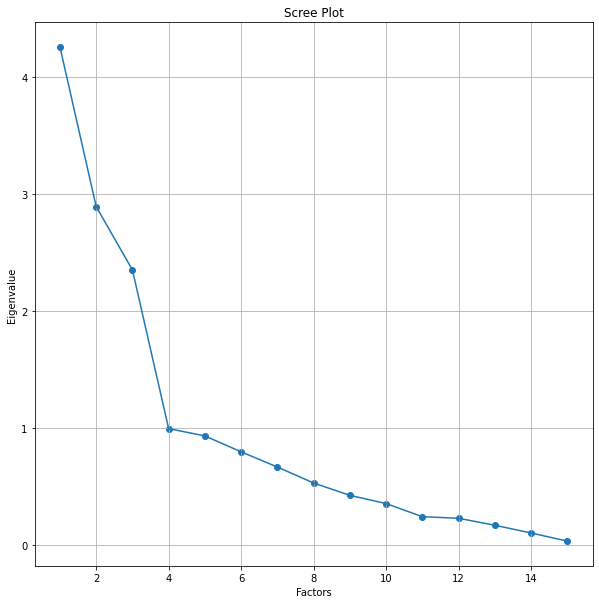

In [116]:
# Create scree plot 
plt.scatter(range(1,analysis_ds.shape[1]+1),ev)
plt.plot(range(1,analysis_ds.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [117]:
fa3 = FactorAnalyzer(method="ml", rotation="quartimin", n_factors=4)
fa3.fit(analysis_ds)
fa3.loadings_

array([[-0.07489733,  0.69474703, -0.23616927,  0.28371006],
       [-0.10059063,  0.36632276,  0.11353856,  0.13595641],
       [-0.02627423,  0.00827292,  0.04284557,  0.98449265],
       [ 0.0748796 ,  0.11032654, -0.09704607,  0.59081207],
       [ 0.02239052,  0.02585594,  0.93342594, -0.01762058],
       [ 0.94999339,  0.03057601, -0.18352259, -0.03377517],
       [ 0.91626455,  0.0049105 ,  0.27109758, -0.01095477],
       [ 0.87853108,  0.05921155, -0.06447986, -0.00445649],
       [ 0.48197174, -0.23526643, -0.04134289,  0.29519225],
       [-0.13227139,  0.06112444,  0.75288581,  0.03404512],
       [ 0.01560998,  0.96445124,  0.0592674 , -0.00162827],
       [ 0.10115805,  0.79040444,  0.09219233, -0.06556869],
       [ 0.19254762, -0.01771957,  0.4975626 , -0.02048218],
       [ 0.21321426,  0.38464115,  0.38645506,  0.08778008],
       [ 0.14975986, -0.04366175, -0.13524803,  0.08338745]])

## These loadings aren't exactly the same.

The factors have changed a bit. Factor 1 remains similar to before.  Factor 2 is also similar, but Factor 3 now appears to be Inpatient and includes the largest amount of variance for Elixhauser Score.  Factor 4 is now about having coverage! So, likely factor 4 is too volatile and shouldn't be included. We should stick to 3 factors and analyze them well!

There are no cross loadings here, except for cost (not a concern - just shows that Factors 2 and 3 share responsibility for the largest amount of cost variance: 58%).  

In [118]:
fa3.get_communalities()

array([0.62455036, 0.17568599, 0.97182029, 0.37625575, 0.87276433,
       0.93824363, 0.91317875, 0.77950038, 0.37649475, 0.58922803,
       0.93392514, 0.64777081, 0.28537662, 0.35046199, 0.04957986])

In [119]:
fa3.get_uniquenesses()

array([0.37544964, 0.82431401, 0.02817971, 0.62374425, 0.12723567,
       0.06175637, 0.08682125, 0.22049962, 0.62350525, 0.41077197,
       0.06607486, 0.35222919, 0.71462338, 0.64953801, 0.95042014])

In [120]:
fa3.get_factor_variance()

(array([2.90160376, 2.39840074, 2.05830309, 1.5265291 ]),
 array([0.19344025, 0.15989338, 0.13722021, 0.10176861]),
 array([0.19344025, 0.35333363, 0.49055384, 0.59232245]))

## Calculate Cronbach's Alpha

Is the scale valid? We are looking for a value between .6 and .7 (or maybe higher)

In [121]:
# This code was written by Max Hilsdorf

def cronbach_alpha(df):
    # 1. Transform the df into a correlation matrix
    df_corr = df.corr(method="spearman")
    
    # 2.1 Calculate N
    # The number of variables equals the number of columns in the df
    N = df.shape[1]
    
    # 2.2 Calculate R
    # For this, we'll loop through the columns and append every
    # relevant correlation to an array calles "r_s". Then, we'll
    # calculate the mean of "r_s"
    rs = np.array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i+1:].values
        rs = np.append(sum_, rs)
    mean_r = np.mean(rs)
    
   # 3. Use the formula to calculate Cronbach's Alpha 
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha

cronbach_alpha(analysis_ds_copy)

0.7946410312933968